In [1]:
datos=spark.read.csv("College.csv",header=True,inferSchema=True)

In [2]:
datos.printSchema(),datos.show(2,vertical=True)

root
 |-- School: string (nullable = true)
 |-- Private: string (nullable = true)
 |-- Apps: integer (nullable = true)
 |-- Accept: integer (nullable = true)
 |-- Enroll: integer (nullable = true)
 |-- Top10perc: integer (nullable = true)
 |-- Top25perc: integer (nullable = true)
 |-- F_Undergrad: integer (nullable = true)
 |-- P_Undergrad: integer (nullable = true)
 |-- Outstate: integer (nullable = true)
 |-- Room_Board: integer (nullable = true)
 |-- Books: integer (nullable = true)
 |-- Personal: integer (nullable = true)
 |-- PhD: integer (nullable = true)
 |-- Terminal: integer (nullable = true)
 |-- S_F_Ratio: double (nullable = true)
 |-- perc_alumni: integer (nullable = true)
 |-- Expend: integer (nullable = true)
 |-- Grad_Rate: integer (nullable = true)

-RECORD 0---------------------------
 School      | Abilene Christian... 
 Private     | Yes                  
 Apps        | 1660                 
 Accept      | 1232                 
 Enroll      | 721                  
 T

(None, None)

In [28]:
from pyspark.ml.feature import StringIndexer

In [32]:
indexador=StringIndexer(inputCol="Private",outputCol="iPrivate")
indice=indexador.fit(datos)
print(indice.labels)
datosI=indice.transform(datos)

['Yes', 'No']


In [3]:
from pandas.plotting import scatter_matrix

In [33]:
datosP=datosI.select("Apps","Accept","Enroll","iPrivate").toPandas()

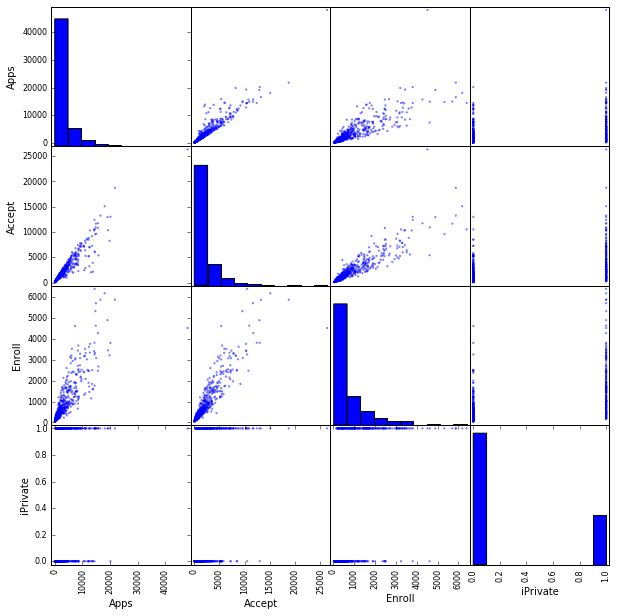

In [34]:
m=scatter_matrix(datosP,figsize=(10,10))

In [36]:
from pyspark.ml.feature import VectorAssembler

In [38]:
print(datosI.columns)

['School', 'Private', 'Apps', 'Accept', 'Enroll', 'Top10perc', 'Top25perc', 'F_Undergrad', 'P_Undergrad', 'Outstate', 'Room_Board', 'Books', 'Personal', 'PhD', 'Terminal', 'S_F_Ratio', 'perc_alumni', 'Expend', 'Grad_Rate', 'iPrivate']


In [39]:
constructor=VectorAssembler(inputCols=['Apps', 'Accept', 
        'Enroll', 'Top10perc', 'Top25perc', 'F_Undergrad', 
        'P_Undergrad', 'Outstate', 'Room_Board', 'Books', 
        'Personal', 'PhD', 'Terminal', 'S_F_Ratio', 
        'perc_alumni', 'Expend', 'Grad_Rate'],outputCol="features")

In [40]:
datosF=constructor.transform(datosI)\
    .select("School","Private","features","iPrivate")

In [42]:
datosF.show(),datosF.groupBy("Private").count().show()

+--------------------+-------+--------------------+--------+
|              School|Private|            features|iPrivate|
+--------------------+-------+--------------------+--------+
|Abilene Christian...|    Yes|[1660.0,1232.0,72...|     0.0|
|  Adelphi University|    Yes|[2186.0,1924.0,51...|     0.0|
|      Adrian College|    Yes|[1428.0,1097.0,33...|     0.0|
| Agnes Scott College|    Yes|[417.0,349.0,137....|     0.0|
|Alaska Pacific Un...|    Yes|[193.0,146.0,55.0...|     0.0|
|   Albertson College|    Yes|[587.0,479.0,158....|     0.0|
|Albertus Magnus C...|    Yes|[353.0,340.0,103....|     0.0|
|      Albion College|    Yes|[1899.0,1720.0,48...|     0.0|
|    Albright College|    Yes|[1038.0,839.0,227...|     0.0|
|Alderson-Broaddus...|    Yes|[582.0,498.0,172....|     0.0|
|   Alfred University|    Yes|[1732.0,1425.0,47...|     0.0|
|   Allegheny College|    Yes|[2652.0,1900.0,48...|     0.0|
|Allentown Coll. o...|    Yes|[1179.0,780.0,290...|     0.0|
|        Alma College|  

(None, None)

In [81]:
entrena,evalua=datosF.randomSplit([0.8,0.2])

In [82]:
from pyspark.ml.classification import (LogisticRegression,
    DecisionTreeClassifier,RandomForestClassifier,GBTClassifier)

In [83]:
lr=LogisticRegression(labelCol="iPrivate")
dt=DecisionTreeClassifier(labelCol="iPrivate")
rf=RandomForestClassifier(labelCol="iPrivate",numTrees=100)
gbt=GBTClassifier(labelCol="iPrivate")

In [84]:
lrModelo=lr.fit(entrena)
dtModelo=dt.fit(entrena)
rfModelo=rf.fit(entrena)
gbtModelo=gbt.fit(entrena)

In [85]:
lrPred=lrModelo.transform(evalua)
dtPred=dtModelo.transform(evalua)
rfPred=rfModelo.transform(evalua)
gbtPred=gbtModelo.transform(evalua)

In [86]:
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                        MulticlassClassificationEvaluator)

In [87]:
evaluadorB=BinaryClassificationEvaluator(labelCol="iPrivate")
evaluadorM=MulticlassClassificationEvaluator(labelCol="iPrivate",
                                metricName="accuracy")

In [88]:
print("lr:",evaluadorB.evaluate(lrPred),
      "dt:",evaluadorB.evaluate(dtPred),
      "rf:",evaluadorB.evaluate(rfPred),
      "gbt:",evaluadorB.evaluate(gbtPred))

lr: 0.9909996785599484 dt: 0.9513821922211506 rf: 0.9937319189971071 gbt: 0.9554001928640303


In [89]:
print("lr:",evaluadorM.evaluate(lrPred),
      "dt:",evaluadorM.evaluate(dtPred),
      "rf:",evaluadorM.evaluate(rfPred),
      "gbt:",evaluadorM.evaluate(gbtPred))

lr: 0.9595375722543352 dt: 0.9364161849710982 rf: 0.9653179190751445 gbt: 0.9132947976878613


In [90]:
modeloOK=rf.fit(datosF)

In [91]:
modeloOK.featureImportances

SparseVector(17, {0: 0.0392, 1: 0.043, 2: 0.1464, 3: 0.0157, 4: 0.0065, 5: 0.2378, 6: 0.0423, 7: 0.2253, 8: 0.0517, 9: 0.0046, 10: 0.0067, 11: 0.0125, 12: 0.0134, 13: 0.0684, 14: 0.0253, 15: 0.0324, 16: 0.0288})

In [92]:
campos=['Apps', 'Accept', 
        'Enroll', 'Top10perc', 'Top25perc', 'F_Undergrad', 
        'P_Undergrad', 'Outstate', 'Room_Board', 'Books', 
        'Personal', 'PhD', 'Terminal', 'S_F_Ratio', 
        'perc_alumni', 'Expend', 'Grad_Rate']

In [94]:
campos[5],campos[7]

('F_Undergrad', 'Outstate')